In [14]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [15]:
data=pd.read_csv('./try.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['Ea','Unnamed: 0'],axis=1)
label=train_data['Ea']
x_test=test_data.drop(['Ea','Unnamed: 0'],axis=1)
y_test=test_data['Ea']

In [16]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [17]:
def ETR_cv(n_estimators, min_samples_split, max_depth):
    val = cross_val_score(
        ExtraTreesRegressor(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_depth=int(max_depth),
            random_state=1314
        ),
        feature, label, scoring='r2', cv=kfold
    ).mean()
    return val

In [18]:
ETR_opt = BayesianOptimization(
        ETR_cv,
        {'n_estimators': (50, 1000),
        'min_samples_split': (2, 25),
        'max_depth': (2, 15)}
    )

In [19]:
ETR_opt.maximize(n_iter=50)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.4439    | 3.306     | 17.32     | 243.8     |
| 2         | 0.6054    | 11.66     | 14.5      | 331.9     |
| 3         | 0.471     | 3.58      | 2.44      | 651.5     |
| 4         | 0.5852    | 8.249     | 20.68     | 474.0     |
| 5         | 0.578     | 6.33      | 18.58     | 451.3     |
| 6         | 0.556     | 4.02      | 3.498     | 379.4     |
| 7         | 0.6055    | 11.25     | 14.43     | 331.0     |
| 8         | 0.5905    | 11.9      | 18.56     | 999.9     |
| 9         | 0.5582    | 4.837     | 2.011     | 916.8     |
| 10        | 0.6753    | 15.0      | 2.0       | 50.0      |
| 11        | 0.3609    | 2.0       | 25.0      | 88.0      |
| 12        | 0.5827    | 13.09     | 19.95     | 51.02     |
| 13        | 0.5862    | 11.67     | 24.94     | 960.5     |
| 14        | 0.3881    | 2.588     | 2.345     | 519.3     |
| 15    

In [20]:
model = ExtraTreesRegressor(n_estimators=1000,
                            # max_depth=26,
                            # min_samples_split=4,
                            # max_samples=105,
                            max_leaf_nodes=10000,
                            # bootstrap=True,
                            random_state=1314).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.6670605533590923
rmse: 0.2060465070512381


In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',mean_absolute_error(label,model.predict(feature)))
print('测试集得分为：', r2_score(y_test,model.predict(x_test)),mean_absolute_error(y_test,model.predict(x_test)))

r2: 0.9898990287100684
MAE: 0.0049523809523889795
测试集得分为： 0.758426428927126 0.11648733333333428


In [22]:
# 预测1
Y1=model.predict(test_data.drop(['Ea','Unnamed: 0'],axis=1))
Y2=test_data['Ea']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [23]:
# 预测2
Y_1=model.predict(X=feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

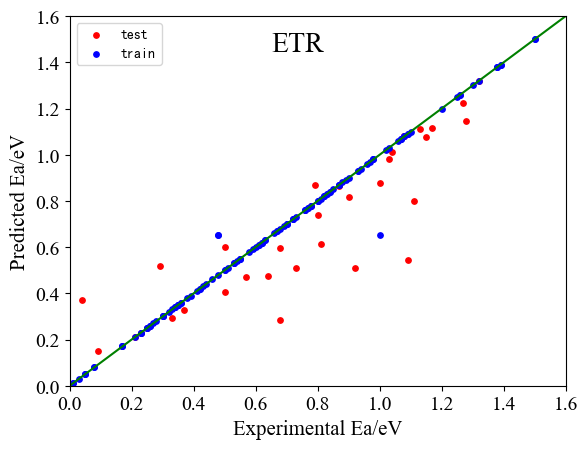

In [24]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,1.6))
plt.xlabel('Experimental Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,1.6))
plt.ylabel('Predicted Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,1.6],[0,1.6],color='g')
plt.text(0.65,1.45,'ETR',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()